In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'#Supress debug info 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
# from sklearn.model_selection import KFold
from sklearn.utils import shuffle

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic
from sklearn.metrics import r2_score

import timeit

### Benchmark Functions from Guo et al.
Guo, M., Manzoni, A, Amendt, M., Conti, P., Hesthaven, J.S., "Multi-fidelity regression using artificial neural networks: efficient approximation of parameter-dependent
output quantities," [arXiv:2102.13403](https://arxiv.org/abs/2102.13403), 2021.

##### Benchmark 1: Low Fidelity Function
$$ y_{lf} = 0.5y_{hf} + 10(x-0.5) + 5 $$

In [2]:
def bench1_lf_func(x):
    y = 0.5*bench1_hf_func(x) + 10.*(x-0.5) + 5.
    return y

##### Benchmark 1: High Fidelity Function
$$ y_{hf} = (6x-2)^2 \sin(12x-4) $$

In [3]:
def bench1_hf_func(x):
    y = ((6.*x-2.)**2)*np.sin(12.*x -4.)
    return y

##### Benchmark 2: Low Fidelity Function
$
\begin{aligned}
y_{lf} &= 0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5) -5, \; \;  0 \leq x < 0.5 \\
&= 3 + 0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5) - 5, \; \; 0.5 \leq x \leq 1.0
\end{aligned}
$

In [4]:
def bench2_lf_func(x):
    if 0 <= x < 0.5:
        y = 0.5*((6.*x-2.)**2)*np.sin(12.*x-4.) + 10.*(x-0.5) - 5.
    else:
        y = 3. + 0.5*((6.*x-2.)**2)*np.sin(12.*x-4.) + 10.*(x-0.5) - 5.
    return y

##### Benchmark 2: High Fidelity Function
$
\begin{aligned}
y_{hf} &= 2y_{lf} - 20(x-1), \; \; 0 \leq x < 0.5 \\
&= 4 + 2y_{lf} - 20(x-1), \; \; 0.5 \leq x \leq 1.0
\end{aligned}
$

In [5]:
def bench2_hf_func(x):
    if 0 <= x < 0.5:
        y = 2.0*bench2_lf_func(x) - 20.0*(x-1.0)
    else: 
        y = 4.0 + 2.0*bench2_lf_func(x) - 20.0*(x-1.0)
    return y

##### Benchmark 3 Low Fidelity Function
$$ y_{lf} = \sin(8 \pi x) $$

In [6]:
def bench3_lf_func(x):
    y = np.sin(8.*np.pi*x)
    return y

##### Benchmark 3 High Fidelity Function
$$ y_{hf} = (x-\sqrt{2})y_{lf}^2 $$

In [7]:
def bench3_hf_func(x):
    y = (x-np.sqrt(2.))*bench3_lf_func(x)*bench3_lf_func(x)
    return y

In [8]:
# Keras NN Model Building 
def buildModel(feats, outs, ref_size, rate, reg):
    """
    :param feats: input parameters/features
    :param outs: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rat
    :param reg: L2 regularization value to drop weights
    :return:
    """
    
    layer1 = ref_size
    layer2 = ref_size
    layer3 = ref_size
        
    ins = keras.Input(shape=(feats,))
    
    x = keras.layers.Dense(layer1, activation=tf.nn.tanh,
                          kernel_regularizer=keras.regularizers.l2(reg),
                          kernel_initializer = tf.keras.initializers.GlorotUniform())(ins)
    
    x = keras.layers.Dense(layer2, activation=tf.nn.tanh,
                          kernel_regularizer=keras.regularizers.l2(reg),
                          kernel_initializer = tf.keras.initializers.GlorotUniform())(x)

    # x = keras.layers.Dense(layer3, activation=tf.nn.tanh,
    #                       kernel_regularizer=keras.regularizers.l2(reg),
    #                       kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    #
    # x = keras.layers.Dense(layer3, activation=tf.nn.leaky_relu,
    #                       kernel_regularizer=keras.regularizers.l2(reg),
    #                       kernel_initializer = tf.keras.initializers.GlorotUniform())(x)

    output = keras.layers.Dense(outs, activation=tf.nn.leaky_relu,
                                kernel_regularizer=keras.regularizers.l2(reg),
                                kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = keras.Model(ins, output)
    
    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError(),
                         tf.keras.metrics.RootMeanSquaredError()])
    return model


def buildModelMF(feats, outs, ref_size, rate, reg):
    """

    :param feats: input parameters/features
    :param outs: outputs the NN is fitting
    :param ref_size: reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    
    layer1 = ref_size
    
    ins = keras.Input(shape=(feats,))
    
    x = keras.layers.Dense(layer1, activation=tf.nn.tanh,
                           kernel_regularizer=keras.regularizers.l2(reg),
                           kernel_initializer = tf.keras.initializers.GlorotUniform())(ins)
    
    output = keras.layers.Dense(outs, activation=tf.nn.leaky_relu,
                                kernel_regularizer=keras.regularizers.l2(reg),
                                kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    model = keras.Model(ins, output)
    
    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError(),
                         tf.keras.metrics.RootMeanSquaredError()])  
    return model


def buildModelMFlinear(feats, outs, ref_size, rate, reg):
    """

    :param feats: input parameters/features
    :param outs: outputs the NN is fitting
    :param ref_size: a reference size for building the NN model
    :param rate: learning rate
    :param reg: L2 regularization value to drop weights
    :return:
    """
    layer1 = ref_size
    
    ins = keras.Input(shape=(feats,))
    
    x = keras.layers.Dense(layer1, activation=tf.nn.leaky_relu,
                           kernel_regularizer=keras.regularizers.l2(reg),
                           kernel_initializer = tf.keras.initializers.GlorotUniform())(ins)
    
    output = keras.layers.Dense(outs, activation=tf.nn.leaky_relu,
                                kernel_regularizer=keras.regularizers.l2(reg),
                                kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    
    model = keras.Model(ins, output)
    
    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError(),
                         tf.keras.metrics.RootMeanSquaredError()])  
    return model


In [9]:
def trainModel(model, myins, myouts, myEpochs, myBatchSize, validSplit):
    """

    :param model:
    :param myins: input parameters/features
    :param myouts: output that the NN is fitting
    :param myEpochs: # of epochs
    :param myBatchSize:
    :param validSplit:
    :return:
    """

    es = keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                       mode='min', patience = 1500, verbose=2)

    history = model.fit(x=myins,
                       y=myouts,
                       batch_size=myBatchSize,
                       epochs=myEpochs,
                       verbose=False,
                       shuffle=False,
                       validation_split=validSplit,
                       use_multiprocessing=True,
                       callbacks=[TqdmCallback(verbose=1), es] 
                       )
    epochs = history.epoch
    return epochs, history.history

In [10]:
def x_samples(benchmark):
    """
    See sampling from Guo et al. benchmarks
    Setting up Benchmark Data
    :param benchmark:
    :return:
    """
    x = np.linspace(0.0, 1.0, num=200).reshape(-1,1)

    if bench==1:
        xl = np.linspace(0.0, 1.0, num=32).reshape(-1,1)
        xh = np.linspace(0.0, 1.0, num=8).reshape(-1,1)
    if bench==2:
        xl1 = np.linspace(0.0,1.0, num=32).reshape(-1,1)
        xl2 = np.linspace(0.45,0.55, num=10).reshape(-1,1)
        xl = np.concatenate((xl1, xl2), axis=0)
        xh = np.linspace(0.0, 1.0, num=8).reshape(-1,1)
    if bench==3:
        xl = np.linspace(0.0, 1.0, num=42).reshape(-1,1)
        xh = np.linspace(0.0, 1.0, num=15).reshape(-1,1)

    return x, xl, xh

In [11]:
def y_samples(benchmark, xl, xh):
    """

    :param benchmark:
    :param x:
    :return:
    """
    # Low Fidelity Data Samples
    yl = np.zeros(shape=np.shape(xl))
    for ix in range(len(xl)):
        xin = xl[ix,0]
        if benchmark==1:
            yl[ix,0] = bench1_lf_func(xin)
        if benchmark==2:
            yl[ix,0] = bench2_lf_func(xin)
        if benchmark==3:
            yl[ix,0] = bench3_lf_func(xin)

    yh = np.zeros(shape=np.shape(xh))
    # High Fidelity Data Samples
    for ix in range(len(xh)):
        xin = xh[ix,0]
        if bench==1:
            yh[ix,0] = bench1_hf_func(xin)
        if bench==2:
            yh[ix,0] = bench2_hf_func(xin)
        if bench==3:
            yh[ix,0] = bench3_hf_func(xin)
    return yl, yh

In [12]:
def y_samples_exact(benchmark, x):
    """

    :param benchmark:
    :param x:
    :return:
    """
    yh = np.zeros(shape=np.shape(x))
    yl = np.zeros(shape=np.shape(x))
    for ix in range(len(x)):
        xin = x[ix,0]
        if benchmark==1:
            yh[ix,0] = bench1_hf_func(xin)
            yl[ix,0] = bench1_lf_func(xin)
        if benchmark==2:
            yh[ix,0] = bench2_hf_func(xin)
            yl[ix,0] = bench2_lf_func(xin)
        if benchmark==3:
            yh[ix,0] = bench3_hf_func(xin)
            yl[ix,0] = bench3_lf_func(xin)
    return yl, yh

### Problem Setup

In [13]:
# Setting up Benchmark Data
bench = 1

ml_train = True
gp_train = True

xi, xlf, xhf = x_samples(bench)
yexactlf, yexacthf = y_samples_exact(bench, xi)
ylf, yhf = y_samples(bench, xlf, xhf)

#### Low-Fidelity Model

In [14]:
if ml_train == True:
    # Training Low Fidelity Model
    #scaler_output_ylf = preprocessing.MinMaxScaler()
    scaler_output_ylf = preprocessing.StandardScaler()

    outputs_ylf = scaler_output_ylf.fit_transform(ylf)
    inTrain = xlf
    outTrain = outputs_ylf
    inTrain, outTrain = shuffle(inTrain, outTrain)  # shuffle data to use validation_split in Keras
    l2reg = 1.0e-6
    lrate = 5.0e-2
    featsize = int(len(inTrain[0,:]))
    outsize = int(len(outTrain[0,:]))
    layer_ref_size = len(inTrain)/2 #16
    myModel_lf = None
    myModel_lf = buildModel(featsize, outsize, layer_ref_size, lrate, l2reg)
    epochLim = 10000
    epochs_lf, history_lf = trainModel(myModel_lf, inTrain, outTrain, epochLim, None, None)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

#### High-Fidelity Model

In [15]:
if ml_train == True:
    # Training High Fidelity Model
    #scaler_output_yhf = preprocessing.MinMaxScaler()
    scaler_output_yhf = preprocessing.StandardScaler()
    outputs_yhf = scaler_output_yhf.fit_transform(yhf)
    myModel_hf = None
    inTrain = xhf
    outTrain = outputs_yhf
    inTrain, outTrain = shuffle(inTrain, outTrain)  # shuffle data to use validation_split in Keras
    #featsize = int(len(inTrain[0,:]))
    #outsize = int(len(outTrain[0,:]))
    #layer_ref_size = int(len(inTrain))
    #epochLim = 10

    #kfold = KFold(n_splits=8, shuffle=True)
    #acc_per_fold = []
    #loss_per_fold = []

    #myModel_hf = buildModel(featsize, outsize, layer_ref_size)
    #count = 1
    #for outer in range(0,100):
    #    fold_no = 1
    #    for train, test in kfold.split(inTrain, outTrain):
    #        print('Training for fold %d' % fold_no)
    #        epochs_hf, history_hf = trainModel(myModel_hf, inTrain[train], outTrain[train], epochLim, 4000, None)
    #        scores = myModel_hf.evaluate(inTrain[test], outTrain[test], verbose=0)
    #        print(f'Score for iter {count}: {myModel_hf.metrics_names[0]} of {scores[0]}; {myModel_hf.metrics_names[1]} of {scores[1]*100}%')
    #        acc_per_fold.append(scores[1] * 100)
    #        loss_per_fold.append(scores[0])
    #        fold_no += 1
    #        count += 1
    #    outer += 1

    featsize = int(len(inTrain[0,:]))
    outsize = int(len(outTrain[0,:]))
    layer_ref_size = len(inTrain) #/2
    myModel_hf = buildModel(featsize, outsize, layer_ref_size, lrate, l2reg)
    epochLim = 10000
    epochs_hf, history_hf = trainModel(myModel_hf, inTrain, outTrain, epochLim, None, None)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Gaussian Process Models
Using the scikit learn Gaussian Process capability, we are building GP models similar to the ML models. 
#### Low Fidelity 
$y_{lf} = GP_{lf}(x_{lf})$
#### High Fidelity 
$y_{hf} = GP_{hf}(x_{hf})$
#### Multi-Fidelity 
$y_{hf} = GP_{mf}(x_{hf},y_{lf}(x_{hf}))$

In [22]:
xhf.shape

(8, 1)

In [16]:
if gp_train == True:
    start = timeit.default_timer()

    #kernel = ConstantKernel(1.0) + Matern(length_scale=0.1, nu=3/2) #+ WhiteKernel(noise_level=1)
    kernel = 1.0*Matern(length_scale=0.1, nu=1.5)
    #kernel = RationalQuadratic()
    #kernel = Matern(length_scale=0.1, nu=2.5)  #
    #kernel = ConstantKernel(1.0, (1e-8, 1e2)) * RBF(0.1, (1e-8, 1e2))
    #kernel = ConstantKernel(1.0, (1e-3, 1e3))*RBF(1.0, (1e-2, 1e2))
    scaler_gp_ylf = preprocessing.StandardScaler()
    scaler_gp_yhf = preprocessing.StandardScaler()

    print("Low Fidelity GP Model")
    gp_lf = None
    gp_lf = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    gp_lf.fit(xlf, scaler_gp_ylf.fit_transform(ylf))
    ylf_gp, ylf_gp_std = gp_lf.predict(xi, return_std=True)
    ylf_gp = scaler_gp_ylf.inverse_transform(ylf_gp)
    ylf_gp_std = ylf_gp_std.reshape(-1,1)
    ylf_gp_std = scaler_gp_ylf.inverse_transform(ylf_gp_std)
    print("GP LF R^2 = %6.3f" % r2_score(ylf_gp,yexactlf))

    print("High Fidelity GP Model")
    gp_hf = None
    gp_hf = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    gp_hf.fit(xhf, scaler_gp_yhf.fit_transform(yhf))
    yhf_gp, yhf_gp_std = gp_hf.predict(xi, return_std=True)
    yhf_gp = scaler_gp_yhf.inverse_transform(yhf_gp)
    yhf_gp_std = yhf_gp_std.reshape(-1,1)
    yhf_gp_std = scaler_gp_yhf.inverse_transform(yhf_gp_std)
    print("GP HF R^2 = %6.3f" % r2_score(yhf_gp,yexacthf))

    print("Multi-Fidelity GP Model")
    gp_mf = None
    gp_mf = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    in_mf = xhf
    ylf_in = gp_lf.predict(in_mf)
    in_mf = np.concatenate((in_mf,ylf_in), axis=1)
    gp_mf.fit(in_mf, scaler_gp_yhf.fit_transform(yhf))
    ylf_in = gp_lf.predict(xi)
    in_mf = np.concatenate((xi,ylf_in), axis=1)
    ymf_gp, ymf_gp_std = gp_mf.predict(in_mf, return_std=True)
    ymf_gp = scaler_gp_yhf.inverse_transform(ymf_gp)
    ymf_gp_std = ymf_gp_std.reshape(-1,1)
    ymf_gp_std = scaler_gp_yhf.inverse_transform(ymf_gp_std)
    print("GP MF R^2 = %6.3f" % r2_score(ymf_gp,yexacthf))
    stop = timeit.default_timer()
    print('Time for GP training = %6.2e sec' % (stop-start))

Low Fidelity GP Model
GP LF R^2 =  1.000
High Fidelity GP Model
GP HF R^2 =  0.946
Multi-Fidelity GP Model


c:\Users\tyler\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GP MF R^2 =  1.000
Time for GP training = 1.35e+00 sec


c:\Users\tyler\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


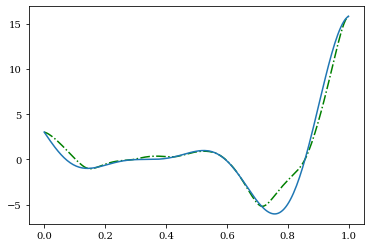

In [20]:
plt.rc('text', usetex=False)
plt.plot(xi,yhf_gp, label="High Fidelity Model Prediction",linestyle="-.", color="green")
plt.plot(xi,yexacthf)

#### 2-Step Multi-Fidelity ML Model

In [73]:
if ml_train == True:
    inTrain = xhf
    yLF_in = myModel_lf.predict(inTrain)
    inTrainML = np.concatenate((inTrain,yLF_in), axis=1)
    layer_ref_size = int(len(inTrainML))
    outTrain = outputs_yhf
    inTrainML, outTrain = shuffle(inTrainML, outTrain)
    featsize = int(len(inTrainML[0,:]))
    outsize = int(len(outTrain[0,:]))
    layer_ref_size = len(inTrainML)
    myModel_mf2 = None
    myModel_mf2 = buildModelMF(featsize, outsize, layer_ref_size, lrate, l2reg)
    epochLim = 10000
    epochs_mf2, history_mf2 = trainModel(myModel_mf2, inTrainML, outTrain, epochLim, None, None)
    #kfold = KFold(n_splits=8, shuffle=True)
    #acc_per_fold = []
    #loss_per_fold = []
    #fold_no = 1
    #count = 1
    #for outer in range(0,1000):
    #    acc_per_fold = 0.0
    #    loss_per_fold = 0.0
    #    for train, test in kfold.split(inTrainML, outTrain):
    #        #        print('Training for fold %d' % fold_no)
    #        epochs_mf2, history_mf2 = trainModel(myModel_mf2, inTrainML[train], outTrain[train], epochLim, 4000, None)
    #        scores = myModel_mf2.evaluate(inTrainML[test], outTrain[test], verbose=0)
    #        acc_per_fold += scores[1] * 100
    #        loss_per_fold += scores[0]
    #        fold_no = fold_no + 1
    #        count += 1
    #    acc_per_fold /= 8
    #    loss_per_fold /= 8
    #    print(f'Score for outer {outer}: {myModel_mf2.metrics_names[0]} of {scores[0]}; {myModel_mf2.metrics_names[1]} of {scores[1]*100}%')

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_54 (Dense)            (None, 15)                45        
                                                                 
 dense_55 (Dense)            (None, 1)                 16        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 08409: early stopping


#### 3-Step Multi-Fidelity ML Model
##### Linear Model

In [74]:
if ml_train == True:
    # 3-Step ML Model
    inTrain = xhf
    yLF_in = myModel_lf.predict(inTrain)
    inTrainML = np.concatenate((xhf,yLF_in), axis=1)
    outTrain = outputs_yhf
    inTrainML, outTrain = shuffle(inTrainML, outTrain)  # shuffle data to use validation_split in Keras
    #l2reg = 2.e-4
    #lrate = 1.e-2
    featsize = int(len(inTrainML[0,:]))
    outsize = int(len(outTrain[0,:]))
    layer_ref_size = len(inTrain)
    myModel_mf3lin = None
    myModel_mf3lin = buildModelMFlinear(featsize, outsize, layer_ref_size, lrate, l2reg)
    epochLim = 10000
    epochs_mf3lin, history_mf3lin = trainModel(myModel_mf3lin, inTrainML, outTrain, epochLim, 4000, None)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_56 (Dense)            (None, 15)                45        
                                                                 
 dense_57 (Dense)            (None, 1)                 16        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

##### Non-Linear Model

In [75]:
if ml_train == True:
    inTrainML = np.concatenate((xhf,yLF_in), axis=1)
    yMF3lin_nn = myModel_mf3lin.predict(inTrainML)
    inTrainML = np.concatenate((inTrainML,yMF3lin_nn), axis=1)
    layer_ref_size = len(inTrain)
    outTrain = outputs_yhf
    #inTrainML, outTrain = shuffle(inTrainML, outTrain)  # shuffle data to use validation_split in Keras
    featsize = int(len(inTrainML[0,:]))
    outsize = int(len(outTrain[0,:]))
    myModel_mf3 = None
    myModel_mf3 = buildModelMF(featsize, outsize, layer_ref_size, lrate, l2reg)
    epochLim = 10000
    epochs_mf3, history_mf3 = trainModel(myModel_mf3, inTrainML, outTrain, epochLim, None, None)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_58 (Dense)            (None, 15)                60        
                                                                 
 dense_59 (Dense)            (None, 1)                 16        
                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 06751: early stopping


### Generating Predictions and Applying Inverse Scaling

In [76]:
if ml_train == True:
    # Predictions
    yLF_nn = myModel_lf.predict(xi)
    yHF_nn = myModel_hf.predict(xi)
    input_MF2 = np.concatenate((xi,yLF_nn), axis=1)
    yMF2_nn = myModel_mf2.predict(input_MF2)
    yMF3lin_nn = myModel_mf3lin.predict(input_MF2)
    input_MF3 = np.concatenate((input_MF2, yMF3lin_nn), axis=1)
    yMF3_nn = myModel_mf3(input_MF3)

    # Inverse-scaling the Data
    yLF_nn = scaler_output_ylf.inverse_transform(yLF_nn)
    yHF_nn = scaler_output_yhf.inverse_transform(yHF_nn)
    yMF2_nn = scaler_output_yhf.inverse_transform(yMF2_nn)
    yMF3_nn = scaler_output_yhf.inverse_transform(yMF3_nn)
    yMF3lin_nn = scaler_output_yhf.inverse_transform(yMF3lin_nn)

### Plotting Results

In [17]:
# Plots of Results
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.style.use({'figure.facecolor':'white'})

# Raw Data and Exact Function
if gp_train == True:
    plt.plot(xi, yexacthf, color='black', label='Exact HF function')
    plt.plot(xi, yexactlf, color='lightblue', label='Exact LF function')
    plt.plot(xhf, yhf, 'o', color='black', label='HF Data')
    plt.plot(xlf, ylf, 'x', color='black', label='LF Data')
    plt.plot(xi, ylf_gp, '-', color='green', label='GP LF')
    plt.fill_between(xi.flatten(), (ylf_gp - ylf_gp_std).flatten(), (ylf_gp + ylf_gp_std).flatten(), color='green', alpha=0.2)
    plt.plot(xi, yhf_gp, '-', color='red', label='GP HF')
    plt.fill_between(xi.flatten(), (yhf_gp - yhf_gp_std).flatten(), (yhf_gp + yhf_gp_std).flatten(), color='red', alpha=0.2)
    plt.plot(xi, ymf_gp, '-', color='blue', label='GP MF')
    plt.fill_between(xi.flatten(), (ymf_gp - ymf_gp_std).flatten(), (ymf_gp + ymf_gp_std).flatten(), color='blue', alpha=0.2)
    plt.legend()
    plt.title("Gaussian Process Models")
    plt.xlabel(r'$x$', fontsize=11)
    plt.ylabel(r'$y$', fontsize=11)
    plt.savefig('./bench-%d-data.png' % bench)
    plt.savefig('./bench-%d-data.pdf' % bench)
    plt.show()

if ml_train == True:
    # Model Comparisons
    plt.plot(xi, yexacthf, color='black', label='Exact HF function')
    plt.plot(xhf, yhf, 'o', color='black', label='HF Data')
    plt.plot(xlf, ylf, 'x', color='black', label='LF Data')
    plt.plot(xi, yLF_nn, '--', color='red', label="SFR LF")
    plt.plot(xi, yHF_nn, '--', color='green', label="SFR HF")
    plt.plot(xi, yMF3lin_nn, color='lightblue', label="MFR 2-Step Linear")
    plt.plot(xi, yMF2_nn, color='orange', label="MFR 2-Step NL")
    plt.plot(xi, yMF3_nn, color='blue', label="MFR 3-Step NL")
    plt.legend()
    plt.title("Neural Network Models")
    plt.xlabel(r'$x$', fontsize=11)
    plt.ylabel(r'$y$', fontsize=11)
    plt.savefig('./bench-%d-compare.png' % bench)
    plt.savefig('./bench-%d-compare.pdf' % bench)
    plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>